2022 July 15th, Transformer can't use Weight_decay!

2022 July 14th, editted for Prelim model structure selection.

2022 July 1st, editted for Prelim Results plotting.

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [59]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import heapq
import os
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
#from utils import progress_bar
from torch.autograd import Variable
import sys
from copy import deepcopy
import random
import collections
from scipy import signal
from drive.MyDrive.Wireless_Transformer.PSDshow import imshow
from drive.MyDrive.Wireless_Transformer.wrt import WrT # customized design of Wireless Transformer
from drive.MyDrive.Wireless_Transformer.AlexNet1D import AlexNet1D
# /content/drive/MyDrive/Wireless_Transformer/AlexNet1D.py
from torch.utils.data import Dataset, DataLoader

 
device = torch.device("cuda")
# torch.manual_seed(0)


In [ ]:
#Learning to export excel files
df1 = pd.DataFrame([['a', 'b'], ['c', 'd']],
                   index=['row 1', 'row 2'],
                   columns=['col 1', 'col 2'])
rootaddr =  '/content/drive/MyDrive/Wireless_Transformer/'
df1.to_excel(rootaddr + "output1.xlsx")

In [ ]:
#Learning to export excel files
xx = [.1,  .2,  .3, .4, .5, .6 ]
yy = [ 1.1, 2.1, 3.1, 4.1, 5.1, 6.1]
df1 = pd.DataFrame()
df1['acc_old'] = xx
df1['acc_proposed'] = yy

rootaddr =  '/content/drive/MyDrive/Wireless_Transformer/'

with pd.ExcelWriter(rootaddr + "output.xlsx",
                    mode='a') as writer:  
  df1.to_excel(writer, sheet_name='Sheet_name_3')
# df1.to_excel(rootaddr + "output.xlsx", sheet_name= "sheet12")

In [60]:
SNR = -7
volum = 1000 # 4000 samples per occupancy pattern
# address1 =  '/content/drive/MyDrive/Wireless_Transformer/MesBondSW/' #WFSC/, SFWC/, AllW/
address1 =  '/content/drive/MyDrive/Wireless_Transformer/LeftRightIndep/' #LeftRightIndep version
# name1 = 'T_8b3P1sig_SNR'+str(SNR)+'.pth' #data of PU with the same sig
name1 = 'T_10b5P5sig_SNR'+str(SNR)+'vol'+str(volum)+'.pth' #10bands, 5PUs, 5 kinds of sig, training & testing together
# name1 = 'Old_Data/T_8b5P_SNR-10.pth' # 10bands failed, test on 8bands. reason found: shouldn't use weight decay for WrT 
# name1 = 'Old_Data/T_8b3P3sig_SNR'+str(SNR)+'.pth' #8 band data with PU have the same sig
data_dict = torch.load(address1 + name1)
# data_dict = torch.load('/content/drive/MyDrive/Wireless_Transformer/Old_Data/T_8b5P_SNR-10.pth') # 10bands failed, test on 8bands
datas_tr = data_dict['training data list']
labels_tr = data_dict['training label list']
datas_te = data_dict['testing data list']
labels_te = data_dict['testing label list']
num_bands = labels_te[0]

#Calculate dataset mean and std 
datas_all = datas_tr+datas_te
data_tens =torch.cat(datas_all,dim=0)
(data_mean, data_std) = ( torch.mean(data_tens).item(), torch.std(data_tens).item() )
print(data_mean, data_std)

4.131838798522949 3.135223865509033


In [89]:
'''Sep12 version, DIY normalization'''
class ToyDatasetMaker(Dataset):
    "Toy version that wrap data/label tensor list into pytorch dataset"
    def __init__(self, data_list, label_list, transformFunc=transforms.Compose([ ]), norm_config=(1,1) ):
        """
        db: a list of input signal tensors, 
        label_list: a list of data labels, align with elements in db.
        """
        self.datasets = data_list
        self.label_list = label_list
        self.transformFunc = transformFunc
        self.norm_config = norm_config
    def __getitem__(self, i):
        img = self.datasets[i]
        img = self.transformFunc(img)
        img = (img-self.norm_config[0])/self.norm_config[1] # added for normalizing non-image
        class_label = self.label_list[i]
        return img, class_label

    def __len__(self):
        return len(self.label_list)

trainset= ToyDatasetMaker(datas_tr, labels_tr, norm_config=(data_mean, data_std) )
testset= ToyDatasetMaker(datas_te, labels_te, norm_config=(data_mean, data_std) )
train_loader = DataLoader(trainset, batch_size=500, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(testset, batch_size=1000, shuffle=False, num_workers=4, pin_memory=True)

In [ ]:
# trainset= ToyDatasetMaker(datas_tr, labels_tr )
# testset= ToyDatasetMaker(datas_te, labels_te )
# train_loader = DataLoader(trainset, batch_size=500, shuffle=True, num_workers=4, pin_memory=True)
# test_loader = DataLoader(testset, batch_size=1000, shuffle=False, num_workers=4, pin_memory=True)

In [ ]:
#long word 320
v = WrT(
    spectra_size = (1, datas_tr[0].size(0)),
    patch_size = (1,320),
    num_bands = labels_te[0].size(0),
    dim = 64, # 512
    depth = 3, #6
    heads = 4, #8
    mlp_dim = 128, #1024
    dropout = 0.1,
    dim_head = 16,
    emb_dropout = 0.1,
    pool = 'mean'
).to(device)

#not good with depth: 3 heads 4 dim 64 mlpdim 128
criterion = nn.BCEWithLogitsLoss()

In [88]:
#short word 64
v = WrT(
    spectra_size = (1, datas_tr[0].size(0)),
    patch_size = (1,64),
    num_bands = labels_te[0].size(0),
    dim = 8, # 512
    depth = 1, #6
    heads = 8, #8
    mlp_dim = 16, #1024
    dropout = 0.1,
    dim_head = 8,
    emb_dropout = 0.1,
    pool = 'mean'
).to(device)

#not good with depth: 3 heads 4 dim 64 mlpdim 128
criterion = nn.BCEWithLogitsLoss()

In [ ]:
# #small word embedding
# v = WrT(
#     spectra_size = (1, datas_tr[0].size(0)),
#     patch_size = (1,4),
#     num_bands = labels_te[0].size(0),
#     dim = 8, # 512
#     depth = 3, #6
#     heads = 4, #8
#     mlp_dim = 8, #1024
#     dropout = 0.1,
#     dim_head = 8,
#     emb_dropout = 0.1,
#     pool = 'mean'
# ).to(device)

# criterion = nn.BCEWithLogitsLoss()
v = WrT(
    spectra_size = (1, datas_tr[0].size(0)),
    patch_size = (1,4),
    num_bands = labels_te[0].size(0),
    dim = 64, # 512
    depth = 3, #6
    heads = 4, #8
    mlp_dim = 128, #1024
    dropout = 0.1,
    dim_head = 16,
    emb_dropout = 0.1,
    pool = 'mean'
).to(device)

#not good with depth: 3 heads 4 dim 64 mlpdim 128
criterion = nn.BCEWithLogitsLoss()

In [ ]:
# JL 14 using
# device = torch.device("cuda")

v = WrT(
    spectra_size = (1, datas_tr[0].size(0)),
    patch_size = (1,64),
    num_bands = labels_te[0].size(0),
    dim = 64, # 512
    depth = 6, #6
    heads = 8, #8
    mlp_dim = 128, #1024
    dropout = 0.1,
    dim_head = 16,
    emb_dropout = 0.1,
    pool = 'mean'
).to(device)

#not good with depth: 3 heads 4 dim 64 mlpdim 128
criterion = nn.BCEWithLogitsLoss()


In [ ]:
#@title Default title text
# JL 17 very big Transformer 
# device = torch.device("cuda")

v = WrT(
    spectra_size = (1, datas_tr[0].size(0)),
    patch_size = (1,64),
    num_bands = labels_te[0].size(0),
    dim = 512, # 512
    depth = 6, #6
    heads = 8, #8
    mlp_dim = 1024, #1024
    dropout = 0.1,
    dim_head = 64,
    emb_dropout = 0.1,
    pool = 'mean'
).to(device)

#not good with depth: 3 heads 4 dim 64 mlpdim 128
criterion = nn.BCEWithLogitsLoss()

In [ ]:
v = AlexNet1D(num_classes = labels_te[0].size(0)).to(device)  # 8 classes before

criterion = nn.BCEWithLogitsLoss()


In [90]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    epoch_inter = 20
#     print("Decrease learning rate every %d epoch by %2f" %(epoch_inter, des))
    #lr = 0.01 * (des ** (epoch // epoch_inter))
    bs = 1#0.2
    lr = 0.01 * bs ** (epoch/epoch_inter)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def train(model, trainloader, epoch):
  #Transformer fail with weight_decay
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.000 )# 0.0003 for 320 token
  adjust_learning_rate(optimizer, epoch)
  running_loss = 0.0
  model.train()
  for i, data in enumerate(trainloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      #inputs = inputs.to(device)
      # if type(model).__name__ == 'WrT':
      inputs = Variable(inputs.view(-1, 1,1,datas_tr[0].size(0)).to(device)) #640
      # inputs = Variable(inputs.view(-1,datas_tr[0].size(0)).to(device))
      labels = Variable(labels.to(device))
      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      # print statistics
      running_loss += loss.item()
  print('Learning rate:', optimizer.param_groups[0]['lr'])
  return model, running_loss

def test(model, testloader, thresh = 0):
  total = 0 #sum of occupation and emptiness
  total_ocp = 0 #occupied bands
  total_emp = 0 #empty bands
  correct = 0
  correct_ocp = 0
  correct_emp = 0
  model.eval()
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in testloader:
          inputs, labels = data
          inputs = Variable(inputs.view(-1,1,1,datas_tr[0].size(0) ).to(device)) #10bands=>640, 8bands=>512
          labels = Variable(labels.to(device)) 
          total_batch = float( torch.tensor(labels.size()).prod() ) 
          total += total_batch
          total_ocp += float(labels.sum())  #occupied bands
          total_emp += float(total_batch - labels.sum())  #empty bands
          # calculate outputs by running images through the network
          outputs = ( model(inputs)> thresh ).bool()
          labels = labels.bool()
          # the class with the highest energy is what we choose as prediction
          correct_ocp += (outputs * labels).sum() 
          correct_emp += (~outputs * ~labels).sum()
          correct = correct_ocp + correct_emp
          if (outputs * labels).sum()+(~outputs * ~labels).sum() != (~(outputs^labels)) .sum():
            print('wrong!', (outputs * labels).sum()+(~outputs * ~labels).sum(),'!=', (~(outputs^labels)).sum())

  print(f'Accuracy of the network on the test images: {100 * correct/total} %')
  return (correct/total, correct_ocp/total_ocp, correct_emp/total_emp) 

In [91]:
nepoch = 200
acc_list = []
acc_ocp_list = []
fa_list = []
# plt.title("Global Model ACC of the proposed method")
max_acc = 0
for i in range(nepoch):
  print('Epoch', i+1,':')      
  acc_ = test(v, test_loader)
  
  
  if acc_[0].cpu().item() > max_acc:
    max_acc = acc_[0].cpu().item()
    # torch.save(v.state_dict(), '/content/drive/MyDrive/Wireless_Transformer/Best_AlexNet1D-10dB.pth')
    if isinstance(v, WrT):
      torch.save(v.state_dict(), '/content/drive/MyDrive/Wireless_Transformer/Best_WrT_PrelimSNR' +str(SNR)+'.pth')
    if isinstance(v, AlexNet1D):
      torch.save(v.state_dict(), '/content/drive/MyDrive/Wireless_Transformer/Best_Alex_PrelimSNR' +str(SNR)+'.pth')

  acc_list.append( acc_[0].cpu().item())
  acc_ocp_list.append(acc_[1].cpu().item())
  fa_list.append((1-acc_[2]).cpu().item())
  

  # plt.plot(acc_list)
  # plt.plot(acc_list)
  # plt.plot(acc_list)
  axis = list( range(nepoch) )
  #plt.title("Training and Testing Acc at Learning Rate %s"%LR)
  l1, = plt.plot( acc_list, color='blue',label='Avg Acc/band')
  l2, = plt.plot( fa_list, color='red', label='FA')
  l3, = plt.plot( acc_ocp_list, color='black', label='Acc 4 busy')
  plt.legend(loc='lower right')
  plt.title('SNR='+str(SNR)+'dB,'+ type(v).__name__+ ' Model ACC reaches %.3f %%' %  (100*max(acc_list))  )
  plt.show()
  #uniform the y axis, label SNR on title
  v, training_loss = train(v, train_loader, epoch=i)# Test first and train then version
  print('training loss: ', training_loss)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# 64dim Transformer reaches 63.87%

In [ ]:
# xx = [.1,  .2,  .3, .4, .5, .6 ]
yy = acc_list
df1 = pd.DataFrame()
# df1['acc_old'] = xx
df1['acc'] = yy

rootaddr =  '/content/drive/MyDrive/Wireless_Transformer/JL27/'

with pd.ExcelWriter(rootaddr + "output"+"SNR"+str(SNR)+".xlsx",
                    mode='a') as writer:  
  df1.to_excel(writer, sheet_name='WrT')

In [92]:
from torchsummary import summary 
# v = AlexNet1D(num_classes = 10).to(device)
summary(v, (1,1,640))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1               [-1, 10, 64]               0
            Linear-2                [-1, 10, 8]             520
           Dropout-3                [-1, 11, 8]               0
         LayerNorm-4                [-1, 11, 8]              16
            Linear-5              [-1, 11, 192]           1,536
           Softmax-6            [-1, 8, 11, 11]               0
            Linear-7                [-1, 11, 8]             520
           Dropout-8                [-1, 11, 8]               0
         Attention-9                [-1, 11, 8]               0
          PreNorm-10                [-1, 11, 8]               0
        LayerNorm-11                [-1, 11, 8]              16
           Linear-12               [-1, 11, 16]             144
             GELU-13               [-1, 11, 16]               0
          Dropout-14               [-1,

In [ ]:
from torchsummary import summary 
v1 = WrT(
    spectra_size = (1, datas_tr[0].size(0)),
    patch_size = (1,64),
    num_bands = labels_te[0].size(0),
    dim = 16, # 512
    depth = 6, #6
    heads = 8, #8
    mlp_dim = 128, #1024
    dropout = 0.1,
    dim_head = 16,
    emb_dropout = 0.1,
    pool = 'mean'
).to(device)
summary(v1, (1,1,640))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1               [-1, 10, 64]               0
            Linear-2               [-1, 10, 16]           1,040
           Dropout-3               [-1, 11, 16]               0
         LayerNorm-4               [-1, 11, 16]              32
            Linear-5              [-1, 11, 384]           6,144
           Softmax-6            [-1, 8, 11, 11]               0
            Linear-7               [-1, 11, 16]           2,064
           Dropout-8               [-1, 11, 16]               0
         Attention-9               [-1, 11, 16]               0
          PreNorm-10               [-1, 11, 16]               0
        LayerNorm-11               [-1, 11, 16]              32
           Linear-12              [-1, 11, 128]           2,176
             GELU-13              [-1, 11, 128]               0
          Dropout-14              [-1, 

In [ ]:
# para_dict=torch.load('/content/drive/MyDrive/Wireless_Transformer/Best_AlexNet1D-10dB.pth')
# v.load_state_dict(para_dict)
# test(v, test_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy of the network on the test images: 72.703125 %


(tensor(0.7270, device='cuda:0'),
 tensor(0.6866, device='cuda:0'),
 tensor(0.7674, device='cuda:0'))

In [ ]:
# '''ROC module of current model'''
# pd3= []
# pfa3 = []
# model = v.load_state_dict('/content/drive/MyDrive/Wireless_Transformer/Best_Transformer16_32_128-10dB.pth')

# for thresh_val in [ (i-50)/12.5 for i in range(100)]: 
#   #[i*0.9999/100 for i in list(range(1,100))]
#   # in [(1-i/50)*5e-8+1e-10 for i in list(range(50))]
#     CNNoutput = test(model, test_loader, thresh=thresh_val) #
#     #testnets( net_list, class_dir, tol_test_loader, thresh_sig = thresh_val )
#     pd3.append(CNNoutput[1].to(torch.device('cpu')))
#     pfa3.append(1-CNNoutput[2].to(torch.device('cpu')))

# plt.title("ROC of " +type(model).__name__+ " method in SNR="+str(SNR)+"dB")
# l3, = plt.plot(pfa3, pd3, '.', color='green', label='Transformer')
# plt.legend(loc='lower right')
# plt.show()

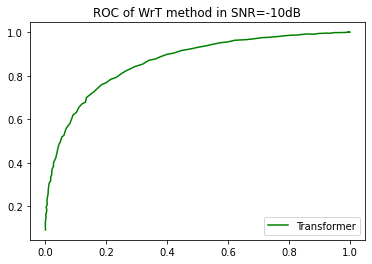

In [ ]:
# plt.title("ROC of " +type(model).__name__+ " method in SNR="+str(SNR)+"dB")
# l3, = plt.plot(pfa3, pd3, color='green', label='Transformer')
# plt.legend(loc='lower right')
# plt.show()

In [ ]:
# '''ROC module of current AlexNet model, saved in pd2 and pfa2'''
# pd2= []
# pfa2 = []
# v.load_state_dict(para_dict)
# model = v

# for thresh_val in [ (i-50)/12.5 for i in range(100)]: 
#   #[i*0.9999/100 for i in list(range(1,100))]
#   # in [(1-i/50)*5e-8+1e-10 for i in list(range(50))]
#     CNNoutput = test(model, test_loader, thresh=thresh_val) #
#     #testnets( net_list, class_dir, tol_test_loader, thresh_sig = thresh_val )
#     pd2.append(CNNoutput[1].to(torch.device('cpu')))
#     pfa2.append(1-CNNoutput[2].to(torch.device('cpu')))

# plt.title("ROC of " +type(model).__name__+ " method in SNR="+str(SNR)+"dB")
# l2, = plt.plot(pfa2, pd2, color='green', label='Transformer')
# plt.legend(loc='lower right')
# plt.show()

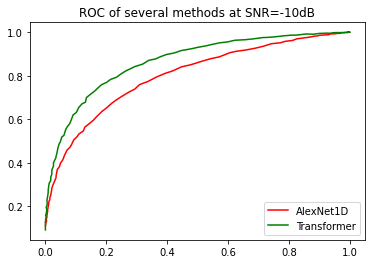

In [ ]:
# plt.title("ROC of several methods at SNR="+str(SNR)+'dB')
# # l1, = plt.plot(pfa, pd, color='blue',label='EnergyDetection1')
# l2, = plt.plot(pfa2, pd2, color='red', label='AlexNet1D')
# l3, = plt.plot(pfa3, pd3, color='green', label='Transformer')
# plt.legend(loc='lower right')
# plt.show()


In [ ]:
# print('SNR=', SNR,'dB， '+ type(v).__name__+ ' Model ACC reaches %.3f %%' %  (100*max(acc_list))  )


SNR= -10 dB， AlexNet1D Model ACC reaches 66.098 %


In [ ]:
# print( type(v).__name__+ ' Model ACC reaches %.3f %%' %  (100*max(acc_list))   )

AlexNet1D Model ACC reaches 66.098 %


In [ ]:
# torch.save(v.state_dict(), '/content/drive/MyDrive/Wireless_Transformer/ToyTransformer16_32_128-10dB.pth')
# # torch.save(v.state_dict(), '/content/drive/MyDrive/Wireless_Transformer/ToyTransformer16_32_128-5dB.pth')
# # torch.save(v.state_dict(), '/content/drive/MyDrive/Wireless_Transformer/ToyAlexNet1D-10dB.pth')
# # torch.save(v.state_dict(), '/content/drive/MyDrive/Wireless_Transformer/ToyAlexNet1D-5dB.pth')

In [ ]:
# torch.save(v.state_dict(), '/content/drive/MyDrive/Wireless_Transformer/ToyAlexNet1D.pth')
# v = WrT(
#     spectra_size = (1, datas_tr[0].size(0)),
#     patch_size = (1,64),
#     num_bands = labels_te[0].size(0),
#     dim = 512,
#     depth = 6,
#     heads = 8,
#     mlp_dim = 1024,
#     dropout = 0.1,
#     emb_dropout = 0.1
# )
# torch.save(v.state_dict(), '/content/drive/MyDrive/Wireless_Transformer/ToyTransformer.pth')

In [ ]:
# import sys
# print(sys.executable)

In [ ]:
# nepoch = 100
# # acc_list = []
# # acc_ocp_list = []
# # fa_list = []
# # plt.title("Global Model ACC of the proposed method")
# max_acc = 0
# for i in range(nepoch):
#   print('Epoch', i+1,':')
#   v, training_loss = train(v, train_loader, epoch=i)
#   acc_ = test(v, test_loader)
#   if acc_[0].cpu().item() > max_acc:
#     max_acc = acc_[0].cpu().item()
#     # torch.save(v.state_dict(), '/content/drive/MyDrive/Wireless_Transformer/Best_Transformer8_16_128-10dB.pth') #JL 1st
#   acc_list.append( acc_[0].cpu().item())
#   acc_ocp_list.append(acc_[1].cpu().item())
#   fa_list.append((1-acc_[2]).cpu().item())
  

#   # plt.plot(acc_list)
#   # plt.plot(acc_list)
#   # plt.plot(acc_list)
#   axis = list( range(nepoch) )
#   #plt.title("Training and Testing Acc at Learning Rate %s"%LR)
#   l1, = plt.plot( acc_list, color='blue',label='Avg Acc/band')
#   l2, = plt.plot( fa_list, color='red', label='FA')
#   l3, = plt.plot( acc_ocp_list, color='black', label='Acc 4 busy')
#   plt.legend(loc='lower right')
#   plt.title('SNR='+str(SNR)+'dB,'+ type(v).__name__+ ' Model ACC reaches %.3f %%' %  (100*max(acc_list))  )
#   plt.show()
#   #uniform the y axis, label SNR on title

In [ ]:
# if isinstance(v, WrT):
#   acc_Transformer = acc_list.copy()
# if isinstance(v, AlexNet1D):
#   acc_CNN = acc_list.copy()  

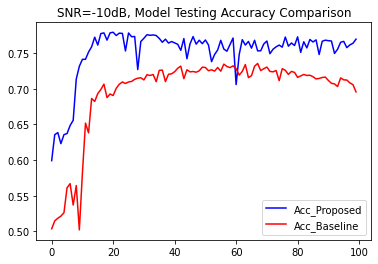

In [ ]:
# acc_dict = {
#     'Acc_proposed': acc_Transformer, 
#     'Acc_baseline': acc_CNN,
# }

# l1, = plt.plot( acc_Transformer, color='blue',label='Acc_Proposed')
# l2, = plt.plot( acc_CNN, color='red', label='Acc_Baseline')
# # l3, = plt.plot( acc_ocp_list, color='black', label='Acc 4 busy')
# plt.legend(loc='lower right')
# plt.title('SNR='+str(SNR)+'dB,'+ ' Model Testing Accuracy Comparison'  )
# plt.show()

Baseline: 69.57%
Transformer: 77.94%

In [ ]:
# if isinstance(v, WrT):
#   torch.save(v.state_dict(), '/content/drive/MyDrive/Wireless_Transformer/EmptyTFM.pth')
# if isinstance(v, AlexNet1D):
#   torch.save(v.state_dict(), '/content/drive/MyDrive/Wireless_Transformer/EmptyAlexNet.pth')